In [106]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import lightgbm as lgb
sys.path.insert(0, 'C:/Users/vitil/OneDrive/Desktop/btc_project')

In [107]:
source_file = 'autoreg.csv'
df = pd.read_csv(f"C:/Users/vitil/OneDrive/Desktop/btc_project/data/{source_file}")
df= df.dropna()
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12307 entries, 3 to 12309
Columns: 2394 entries, ds to target_max_w720_lag1
dtypes: datetime64[ns](1), float64(2393)
memory usage: 224.9 MB


In [108]:
df = df.tail(10000)

In [109]:
df.head(5)

,ds,weights,y_mean_ratio_3_6_lag1,y_mean_ratio_3_12_lag1,y_mean_ratio_3_24_lag1,y_mean_ratio_3_48_lag1,y_mean_ratio_3_120_lag1,y_mean_ratio_3_168_lag1,y_mean_ratio_3_336_lag1,y_mean_ratio_6_12_lag1,...,target_std_w720_lag1,target_skew_w720_lag1,target_kurt_w720_lag1,target_min_w720_lag1,target_q10_w720_lag1,target_q25_w720_lag1,target_q50_w720_lag1,target_q75_w720_lag1,target_q90_w720_lag1,target_max_w720_lag1
2310,2024-05-16 09:00:00,0.12493,1.002089,1.001844,1.014491,1.042133,1.059936,1.062753,1.060565,0.999756,...,388.039987,-0.349188,6.990149,-2264.685235,-335.637618,-94.827927,77.235839,224.826270,435.660635,2515.57848
2311,2024-05-16 10:00:00,0.12493,1.003156,1.003258,1.014162,1.042705,1.061334,1.064414,1.062304,1.000101,...,388.164985,-0.352754,6.979868,-2264.685235,-335.637618,-94.827927,77.680082,226.049222,435.660635,2515.57848
2312,2024-05-16 11:00:00,0.12493,1.002392,1.003328,1.012046,1.041329,1.060712,1.064015,1.062026,1.000933,...,387.087878,-0.353116,7.073066,-2264.685235,-330.699931,-94.232252,78.128623,226.049222,435.660635,2515.57848
2313,2024-05-16 12:00:00,0.12493,1.001612,1.003994,1.010503,1.040808,1.060991,1.064566,1.062727,1.002379,...,387.363087,-0.352578,7.048249,-2264.685235,-330.699931,-94.232252,78.128623,226.049222,438.386522,2515.57848
2314,2024-05-16 13:00:00,0.12493,0.999699,1.002302,1.007267,1.037452,1.058358,1.062219,1.060462,1.002604,...,387.465334,-0.351003,7.037129,-2264.685235,-330.699931,-94.827927,78.128623,226.049222,438.386522,2515.57848


In [110]:
from catboost import CatBoostRegressor, Pool

n_samples = len(df)
train_idx = int(0.8 * n_samples)
val_idx = int(0.9 * n_samples)
train_data = df.iloc[:train_idx]
val_data = df.iloc[train_idx:val_idx]
test_data = df.iloc[val_idx:]

max_weight = train_data['weights'].max()
train_data['weights'] = train_data['weights'] / max_weight

feature_cols = [col for col in df.columns if col not in ['ds', 'y', 'target', 'weights']]
X_train = train_data[feature_cols].values
y_train = train_data['target'].values
X_val = val_data[feature_cols].values
y_val = val_data['target'].values
X_test = test_data[feature_cols].values
y_test = test_data['target'].values

train_pool = Pool(
    data=X_train,
    label=y_train,
    weight=train_data['weights'].values,
    feature_names=feature_cols
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    #weight=val_data['weights'].values,
    feature_names=feature_cols
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Train samples: 8000
Validation samples: 1000
Test samples: 1000


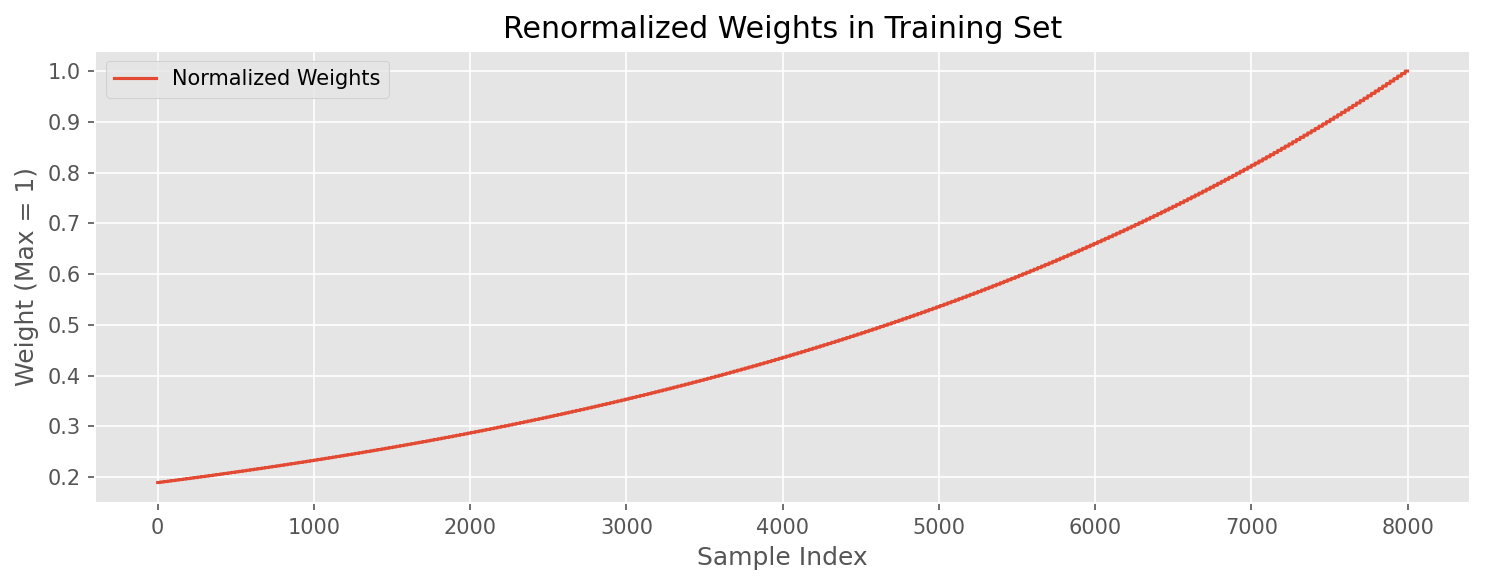

In [111]:
plt.figure(figsize=(10, 4))
plt.plot(train_data['weights'].values, label='Normalized Weights')
plt.title('Renormalized Weights in Training Set')
plt.xlabel('Sample Index')
plt.ylabel('Weight (Max = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
alpha = 0.75
k = 5.0

class CustomLoss:
    def __init__(self, alpha=0.6, k=2.5):
        self.alpha = alpha
        self.k = k
    
    def calc_ders_range(self, approxes, targets, weights):
        # approxes and targets are indexed containers, not numpy arrays
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        
        # Iterate through each element
        for i in range(len(approxes)):
            # Get individual values
            approx = float(approxes[i])
            target = float(targets[i])
            
            # Calculate z for sigmoid
            z = target * approx
            
            # Avoid overflow in exp
            if z > 5000:
                sigmoid = 1.0
            elif z < -5000:
                sigmoid = 0.0
            else:
                sigmoid = 1.0 / (1.0 + np.exp(-self.k * z))
            
            # First derivative (gradient) - CatBoost expects negative gradient
            grad = -(2 * self.alpha * (approx - target) - (1 - self.alpha) * target * sigmoid)
            
            # Second derivative (hessian) - CatBoost expects negative hessian
            hess = -(2 * self.alpha + (1 - self.alpha) * self.k * target**2 * sigmoid * (1 - sigmoid))
            
            # Apply weights if provided
            if weights is not None:
                grad *= float(weights[i])
                hess *= float(weights[i])
            
            result.append((grad, hess))
        
        return result


In [113]:
class CustomLossMetric:
    """
    Implements the exact same metric as the LightGBM softplus_custom_eval_metric.
    Calculates: alpha * (y_pred - y_true)^2 + (1-alpha)/k * log(1 + exp(-k*y_true*y_pred))
    """
    def __init__(self, alpha=0.6, k=2.5):
        self.alpha = alpha
        self.k = k
    
    def evaluate(self, approxes, target, weight):
        # approxes is a list of lists for some reason in CatBoost
        assert len(approxes) == 1
        approx = approxes[0]
        assert len(target) == len(approx)
        
        error_sum = 0.0
        weight_sum = 0.0
        
        # Calculate the actual loss value for each prediction
        for i in range(len(approx)):
            # Get individual values
            y_pred = float(approx[i])
            y_true = float(target[i])
            
            # Calculate the loss components
            # MSE component
            mse_component = self.alpha * (y_pred - y_true)**2
            
            # Softplus penalty component
            z = y_true * y_pred
            
            # Calculate softplus: log(1 + exp(-k*z))
            # Use stable computation to avoid overflow
            if -self.k * z > 700:
                # When -k*z is very large, log(1 + exp(-k*z)) ≈ -k*z
                penalty = -self.k * z
            else:
                # Normal computation
                penalty = np.log(1 + np.exp(-self.k * z))
            
            # Apply scaling factor (1-alpha)/k
            penalty_component = (1 - self.alpha) / self.k * penalty
            
            # Total loss for this sample
            loss_i = mse_component + penalty_component
            
            # Handle weights
            weight_i = 1.0 if weight is None else float(weight[i])
            
            error_sum += weight_i * loss_i
            weight_sum += weight_i
        
        return error_sum, weight_sum
    
    def get_final_error(self, error, weight):
        # Return the average loss
        return error / (weight + 1e-38)  # Add small epsilon to avoid division by zero
    
    def is_max_optimal(self):
        # Lower loss is better, so return False
        return False

In [114]:
# CatBoost parameters (converted from LightGBM)
params = {
    'loss_function': CustomLoss(alpha=alpha, k=k),
    'eval_metric': CustomLossMetric(alpha=alpha, k=k), 
    'grow_policy': 'SymmetricTree',
    'iterations':1500,  # equivalent to num_boost_round
    'learning_rate': 0.005,
    'depth': 6,  # approximate equivalent to num_leaves=64
    'rsm': 0.85,  # equivalent to feature_fraction
    'min_data_in_leaf': 10,  # same parameter name
    'thread_count': -1,  # equivalent to num_threads
    'random_seed': 42,  # equivalent to seed
    'allow_writing_files': False,  # disable file outputs
    'early_stopping_rounds':200, 
    'task_type': 'CPU',  # explicitly set to CPU to avoid GPU-related issues
}

print("Training CatBoost model with custom loss...")

# Create and train the model
model = CatBoostRegressor(**params)
model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,  # equivalent to not using early stopping
    verbose=50
)

Training CatBoost model with custom loss...
0:	learn: 217766.1388299	test: 153631.9215298	best: 153631.9215298 (0)	total: 214ms	remaining: 5m 20s
50:	learn: 215297.8647341	test: 151715.7248391	best: 151715.7248391 (50)	total: 7.56s	remaining: 3m 34s
100:	learn: 203151.6992703	test: 141075.1674701	best: 141075.1674701 (100)	total: 14.7s	remaining: 3m 23s
150:	learn: 192456.7566479	test: 132770.4591060	best: 132770.4591060 (150)	total: 21.6s	remaining: 3m 12s
200:	learn: 184626.1376079	test: 127590.4776649	best: 127590.4776649 (200)	total: 28.3s	remaining: 3m 3s
250:	learn: 178663.6234786	test: 124286.4910989	best: 124286.4910989 (250)	total: 34.9s	remaining: 2m 53s
300:	learn: 173944.7109813	test: 122343.3763560	best: 122343.3763560 (300)	total: 41.6s	remaining: 2m 45s
350:	learn: 169985.9850517	test: 121388.4708554	best: 121388.4708554 (350)	total: 48.2s	remaining: 2m 37s
400:	learn: 166407.3964927	test: 120765.4953095	best: 120765.4953095 (400)	total: 54.8s	remaining: 2m 30s
450:	lear

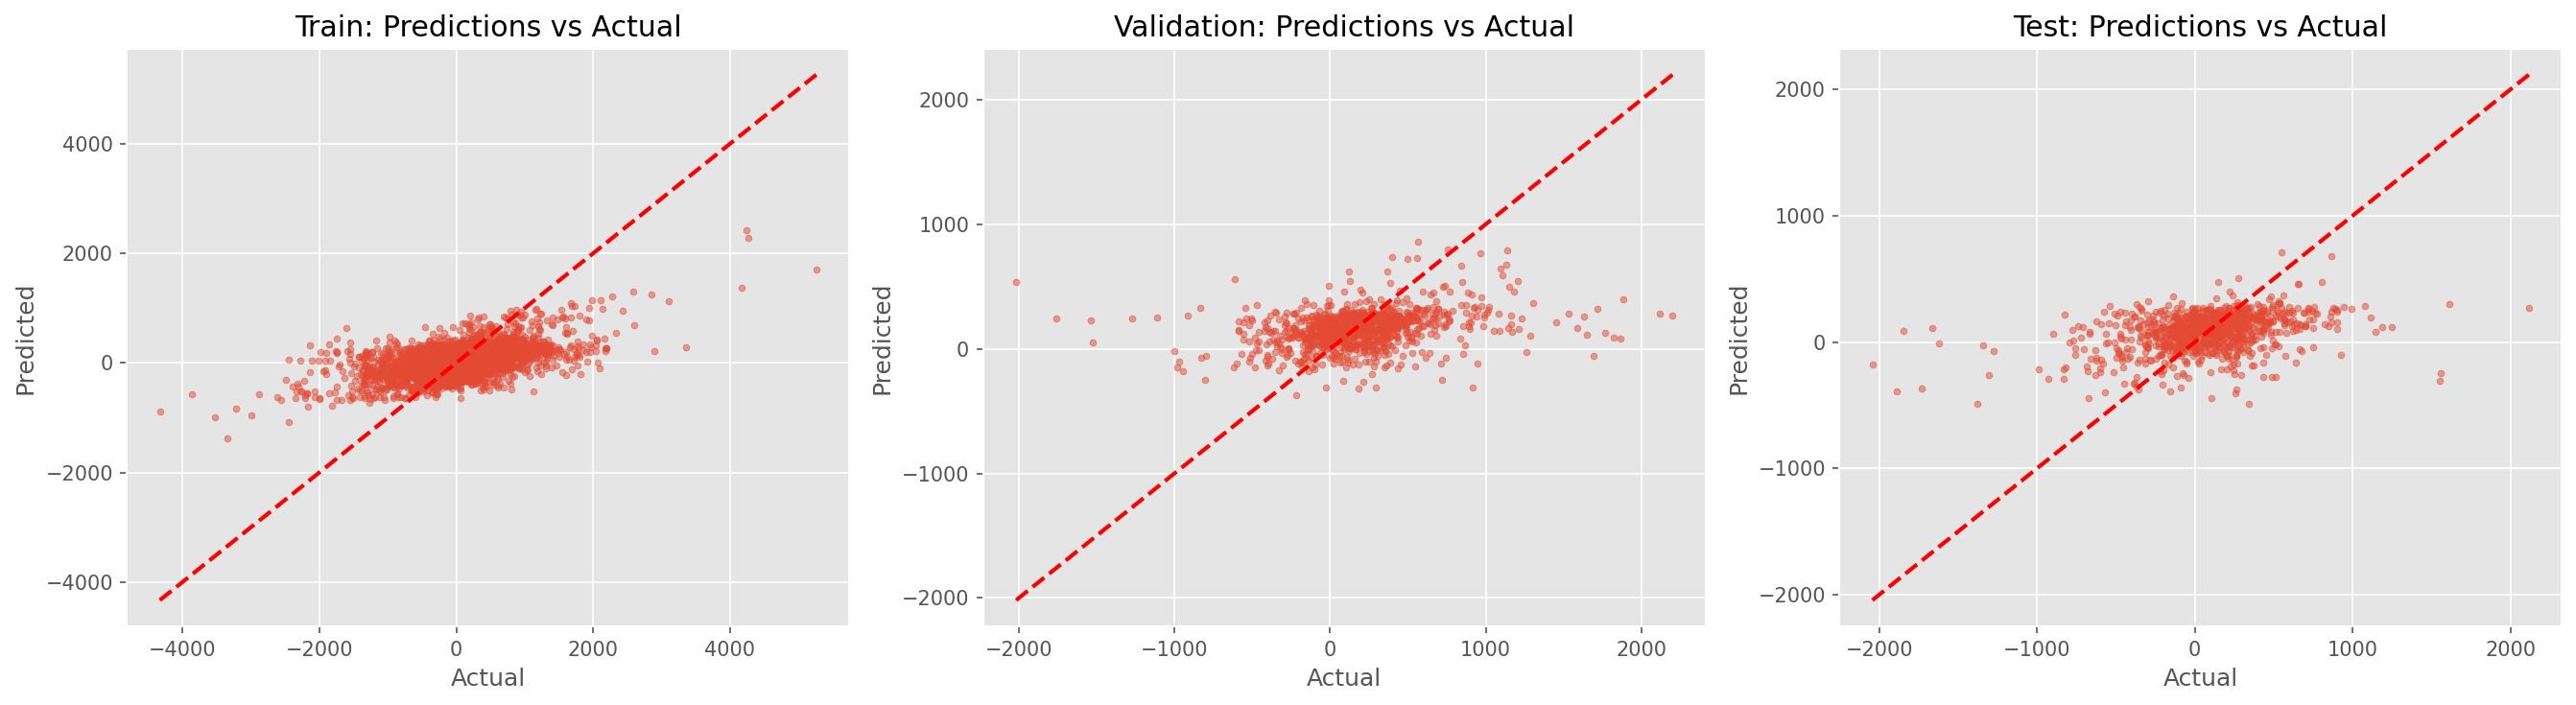


Model Performance Metrics:
                           Train  Validation        Test
Mean Absolute Loss    276.917235  271.568964  246.814304
Directional Accuracy    0.677375    0.709000    0.658000


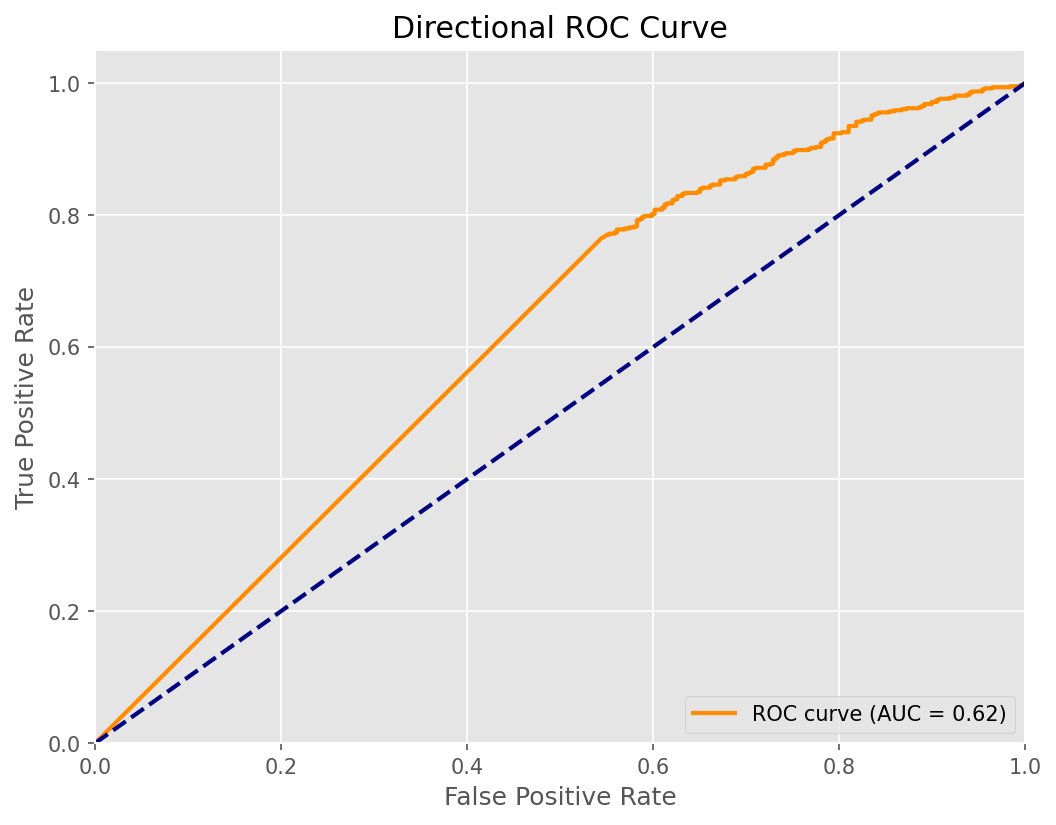

In [115]:
# Cell 8: Model evaluation
# Generate predictions
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

# Create 3 subplots for predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train predictions
axes[0].scatter(y_train, train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Train: Predictions vs Actual')

# Validation predictions
axes[1].scatter(y_val, val_pred, alpha=0.5, s=10)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Validation: Predictions vs Actual')

# Test predictions
axes[2].scatter(y_test, test_pred, alpha=0.5, s=10)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Test: Predictions vs Actual')

plt.tight_layout()
plt.show()

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    # Mean absolute loss
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Directional accuracy
    direction_correct = np.sum(np.sign(y_true) == np.sign(y_pred))
    directional_acc = direction_correct / len(y_true)
    
    return mae, directional_acc

# Generate metrics table
train_mae, train_dir_acc = calculate_metrics(y_train, train_pred)
val_mae, val_dir_acc = calculate_metrics(y_val, val_pred)
test_mae, test_dir_acc = calculate_metrics(y_test, test_pred)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Train': [train_mae, train_dir_acc],
    'Validation': [val_mae, val_dir_acc],
    'Test': [test_mae, test_dir_acc]
}, index=['Mean Absolute Loss', 'Directional Accuracy'])

print("\nModel Performance Metrics:")
print(metrics_df)

# Plot directional ROC curve
from sklearn.metrics import roc_curve, auc

# Convert to binary classification problem (positive vs negative direction)
y_test_binary = (y_test > 0).astype(int)
y_pred_binary_proba = 1 / (1 + np.exp(-test_pred))  # Sigmoid transformation for probability

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_binary_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Directional ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

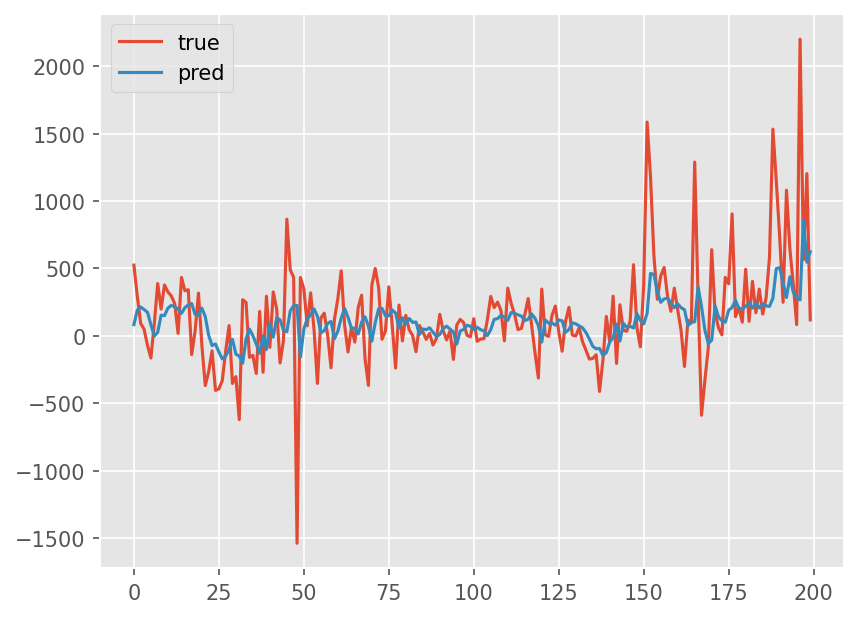

In [116]:
k=200
plt.plot(y_val[:k], label = 'true')
plt.plot(val_pred[:k],label = 'pred')
plt.legend()
plt.show()

In [117]:
from utils.fracdiff import get_weights

D_DEFAULT=0.75
THRESHOLD=0.0012